In [30]:
import numpy as np
import pandas as pd

# df = pd.read_csv('/content/drive/MyDrive/ChatGPTvHumans/yahoo_answers_csv/humans_v_davinci_5050.csv')
df = pd.read_csv('/content/drive/MyDrive/ChatGPTvHumans/stackoverflow_answers_csv/stackoverflow_chatgpt_5050.csv')

In [31]:
df_analysis = df
df_analysis.tail()

,data,label
2369,"(edit: the model name ""Transaction"" may cause ...",chatgpt
2370,Service Pack 1 added the following feature:If ...,chatgpt
2371,I found a solution at :http://www.iphonedevsdk...,chatgpt
2372,the following statement in C# string xmlSample...,chatgpt
2373,Having the SQL pulled out into separate functi...,chatgpt


In [32]:
# yahoo v davinci
# df_human = df_analysis[0:4954]
# df_chatgpt = df_analysis[4954:9908]

# stackoverflow v 
df_human = df_analysis[0:1187]
df_chatgpt = df_analysis[1187:2374]

print(df_human.shape,df_chatgpt.shape)
human_data = df_human['data']
chatgpt_data = df_chatgpt['data']
print(len(human_data),len(chatgpt_data))

(1187, 2) (1187, 2)
1187 1187


In [4]:
import tensorflow_hub as hub

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)

In [5]:
!pip install bert-tensorflow &> /dev/null
!pip install sentencepiece &> /dev/null

In [6]:
!pip install tokenization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
df_analysis = df_analysis.astype(str)

In [8]:
from bert import tokenization
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
# The 4 next lines allows to prevent an error due to Bert version
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

train_input = bert_encode(df_analysis.data.values, tokenizer, max_len=100)
train_labels = df_analysis.label.values

In [9]:
def build_model(bert_layer, max_len=512):
    input_word_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids],)
    clf_output = sequence_output[:, 0, :]

    flatten = layers.Flatten(name='flatten')
    output_flatten = flatten(clf_output)

    out = layers.Dense(len(np.unique(train_labels)), activation='sigmoid')(output_flatten)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(bert_layer, max_len=100)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
label_dummy = pd.get_dummies(train_labels)
label_dummy.tail()

,chatgpt,human
2369,1,0
2370,1,0
2371,1,0
2372,1,0
2373,1,0


In [11]:
train_history = model.fit(
    train_input, label_dummy,
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
60/60 [==============================] - 58s 215ms/step - loss: 0.9132 - accuracy: 0.5893 - val_loss: 1.0409 - val_accuracy: 0.0000e+00
Epoch 2/10
60/60 [==============================] - 10s 168ms/step - loss: 0.6852 - accuracy: 0.6145 - val_loss: 1.0155 - val_accuracy: 0.0000e+00
Epoch 3/10
60/60 [==============================] - 8s 124ms/step - loss: 0.6721 - accuracy: 0.6051 - val_loss: 1.2669 - val_accuracy: 0.0000e+00
Epoch 4/10
60/60 [==============================] - 7s 114ms/step - loss: 0.6715 - accuracy: 0.6251 - val_loss: 1.0796 - val_accuracy: 0.0000e+00
Epoch 5/10
60/60 [==============================] - 6s 102ms/step - loss: 0.6823 - accuracy: 0.6029 - val_loss: 1.1206 - val_accuracy: 0.0000e+00
Epoch 6/10
60/60 [==============================] - 6s 98ms/step - loss: 0.6675 - accuracy: 0.6251 - val_loss: 1.1234 - val_accuracy: 0.0000e+00
Epoch 7/10
60/60 [==============================] - 6s 93ms/step - loss: 0.6683 - accuracy: 0.6251 - val_loss: 0.8326 - val

In [12]:
model.layers

In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 104.1 MB/s eta 0:00:00


In [13]:
from transformers import BertModel, BertConfig, BertTokenizer

config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True, trainable=True)
model = BertModel.from_pretrained("bert-base-uncased", config=config)



tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Example input text
text = "This is a positive review."

# Tokenize input text
tokens = tokenizer.encode_plus(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')

max_len = 100
input_word_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")


outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])
print(len(outputs))  # 3

hidden_states = outputs[2]
print(len(hidden_states))  # 13

embedding_output = hidden_states[0]
attention_hidden_states = hidden_states[1:]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


3
13


In [14]:
df_output = pd.DataFrame(columns=['human','chatgpt','hidden_layer_1','hidden_layer_2','hidden_layer_3','hidden_layer_4','hidden_layer_5','hidden_layer_6','hidden_layer_7','hidden_layer_8','hidden_layer_9','hidden_layer_10','hidden_layer_11','hidden_layer_12','hidden_layer_13'])
df_output.head()

,human,chatgpt,hidden_layer_1,hidden_layer_2,hidden_layer_3,hidden_layer_4,hidden_layer_5,hidden_layer_6,hidden_layer_7,hidden_layer_8,hidden_layer_9,hidden_layer_10,hidden_layer_11,hidden_layer_12,hidden_layer_13


In [16]:
from transformers import BertTokenizer, BertModel
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, config=config)

# Example input text
text = "This is a positive review."

# Tokenize input text
tokens = tokenizer.encode_plus(text, max_length=128, padding='max_length', truncation=True, return_tensors='pt')

# Forward pass through BERT model
outputs = model(input_ids=tokens['input_ids'], attention_mask=tokens['attention_mask'])

# Get hidden states for all layers
hidden_states = outputs.hidden_states

# Compute cosine similarity between hidden states for two tokens in a layer
layer_num = 0 # Layer number (0-12)
token1_idx = 1 # Index of first token
token2_idx = 1 # Index of second token

layer_hidden = hidden_states[layer_num]
layer_hidden = layer_hidden.squeeze(0)
layer_hidden = F.normalize(layer_hidden, p=2, dim=-1) # normalize hidden states
cos_similarity = torch.dot(layer_hidden[token1_idx], layer_hidden[token2_idx]) # compute cosine similarity

# Print cosine similarity
print(cos_similarity.item())

# Compute cosine similarity between hidden states for each layer
# cos_similarities = []
# for i in range(len(hidden_states)):
#     layer_hidden = hidden_states[i]
#     layer_hidden = layer_hidden.squeeze(0)
#     layer_hidden = F.normalize(layer_hidden, p=2, dim=-1) # normalize hidden states
#     cos_similarity = torch.mm(layer_hidden, layer_hidden.transpose(0, 1)) # compute pairwise cosine similarity
#     print(cos_similarity[0])
#     cos_similarity = cos_similarity.detach().cpu().numpy() # convert to numpy array
#     cos_similarities.append(cos_similarity)


# # Visualize cosine similarity matrices as heatmaps
# fig, axs = plt.subplots(3, 4, figsize=(12, 9))
# for i in range(len(cos_similarities)):
#     ax = axs[i // 4][i % 4]
#     ax.imshow(cos_similarities[i], cmap='coolwarm', vmin=-1, vmax=1)
#     ax.set_title("Layer {}".format(i+1))
# plt.tight_layout()
# plt.show()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.9999998211860657


In [17]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, config=config)

index = 0

for human, chatgpt in zip(human_data, chatgpt_data):
  # Example input texts
  text1 = human
  text2 = chatgpt

  # Tokenize input texts
  tokens1 = tokenizer.encode_plus(text1, max_length=128, padding='max_length', truncation=True, return_tensors='pt')
  tokens2 = tokenizer.encode_plus(text2, max_length=128, padding='max_length', truncation=True, return_tensors='pt')

  # Forward pass through BERT model
  outputs1 = model(input_ids=tokens1['input_ids'], attention_mask=tokens1['attention_mask'])
  outputs2 = model(input_ids=tokens2['input_ids'], attention_mask=tokens2['attention_mask'])

  # Get hidden states for all layers
  hidden_states1 = outputs1.hidden_states
  hidden_states2 = outputs2.hidden_states

  print(hidden_states1[0])
  # Compute cosine similarity between hidden states for each pair of tokens
  cos_similarities = []
  similarity = []
  for i in range(len(hidden_states1)):
      layer_hidden1 = hidden_states1[i].squeeze(0)
      layer_hidden2 = hidden_states2[i].squeeze(0)
      layer_hidden1 = F.normalize(layer_hidden1, p=2, dim=-1) # normalize hidden states
      layer_hidden2 = F.normalize(layer_hidden2, p=2, dim=-1) # normalize hidden states
      cos_similarity = torch.mm(layer_hidden1, layer_hidden2.transpose(0, 1)) # compute pairwise cosine similarity
      cos_similarity = cos_similarity.detach().cpu().numpy() # convert to numpy array
      similarity.append(sum([np.mean(s) for s in cos_similarity])/len(cos_similarity))
      cos_similarities.append(cos_similarity)

  df_output.loc[index,["human"]] = text1
  df_output.loc[index,["chatgpt"]] = text2
  df_output.loc[index,["hidden_layer_1"]] = similarity[0]
  df_output.loc[index,["hidden_layer_2"]] = similarity[1]
  df_output.loc[index,["hidden_layer_3"]] = similarity[2]
  df_output.loc[index,["hidden_layer_4"]] = similarity[3]
  df_output.loc[index,["hidden_layer_5"]] = similarity[4]
  df_output.loc[index,["hidden_layer_6"]] = similarity[5]
  df_output.loc[index,["hidden_layer_7"]] = similarity[6]
  df_output.loc[index,["hidden_layer_8"]] = similarity[7]
  df_output.loc[index,["hidden_layer_9"]] = similarity[8]
  df_output.loc[index,["hidden_layer_10"]] = similarity[9]
  df_output.loc[index,["hidden_layer_11"]] = similarity[10]
  df_output.loc[index,["hidden_layer_12"]] = similarity[11]
  df_output.loc[index,["hidden_layer_13"]] = similarity[12]

  index = index + 1

df_output.head(100)
# Compute average cosine similarity across all tokens and layers
# avg_cos_similarity = sum([np.mean(s) for s in cos_similarities]) / len(cos_similarities)

# Print average cosine similarity
# print(avg_cos_similarity)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Streaming output truncated to the last 5000 lines.
       grad_fn=<NativeLayerNormBackward0>)
tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [ 0.5812,  0.6695,  0.1027,  ...,  0.2468,  0.3671,  0.1771],
         [ 0.3351, -0.5599,  0.3153,  ..., -0.9216,  0.6072, -0.1165],
         ...,
         [ 0.3484,  1.1096,  1.0332,  ..., -1.0953, -0.6700,  0.4694],
         [-0.4960,  0.5803,  0.2590,  ..., -0.1133,  0.6159,  0.6948],
         [-0.3914,  0.4674,  0.4943,  ..., -0.5055, -0.1268, -0.0420]]],
       grad_fn=<NativeLayerNormBackward0>)
tensor([[[ 0.1686, -0.2858, -0.3261,  ..., -0.0276,  0.0383,  0.1640],
         [-0.2879,  0.5019,  0.4829,  ...,  0.7862,  0.6945,  0.2708],
         [ 0.9751, -0.7288,  0.6769,  ..., -0.2160,  0.0722, -1.5047],
         ...,
         [-0.1207, -0.1962, -0.2442,  ..., -1.5685, -0.1785,  0.9638],
         [ 0.3030,  0.1707,  0.8560,  ...,  0.2945,  1.0577,  1.2176],
         [-0.3914,  0.4674,  0.4943,  ..., -0.5055, 

,human,chatgpt,hidden_layer_1,hidden_layer_2,hidden_layer_3,hidden_layer_4,hidden_layer_5,hidden_layer_6,hidden_layer_7,hidden_layer_8,hidden_layer_9,hidden_layer_10,hidden_layer_11,hidden_layer_12,hidden_layer_13
0,[There are several ways to solve a system of l...,Cramer's RuleandGaussian Eliminationare two go...,0.067009,0.135182,0.161306,0.153936,0.177014,0.208196,0.207254,0.211853,0.217021,0.197631,0.222891,0.272265,0.269875
1,"In Visual Studio 2003, it is not possible to w...","First: Yes, this is something that belongs in ...",0.086327,0.161096,0.18974,0.181362,0.210294,0.248976,0.240586,0.248118,0.265303,0.248606,0.277285,0.336039,0.309692
2,Here's an equivalent LINQ query to the SQL que...,"A solution, albeit one that defers handling of...",0.083266,0.164965,0.208713,0.201161,0.213562,0.243189,0.238553,0.249724,0.249232,0.245567,0.268717,0.324281,0.303276
3,There are several ways to handle concurrent ed...,"If you expect infrequent collisions, Optimisti...",-0.03193,0.117761,0.206047,0.209914,0.246655,0.302623,0.286222,0.272089,0.282328,0.27771,0.310105,0.372778,0.268776
4,You can detect which font is being used in a w...,"I've seen it done in a kind of iffy, but prett...",0.074583,0.144448,0.177526,0.171008,0.195413,0.229233,0.223978,0.229008,0.235439,0.223653,0.246244,0.308561,0.282232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Verifying files by checking their size and dat...,The only 100% way to figure out if two files a...,0.086259,0.165105,0.19065,0.177209,0.205109,0.244141,0.236291,0.240439,0.250593,0.241655,0.261306,0.316136,0.294852
96,When it comes to choosing a font for programmi...,Either Consolas (download) or Andale Mono (dow...,0.030939,0.122997,0.18339,0.178568,0.207204,0.251243,0.24156,0.238733,0.247632,0.237526,0.273247,0.335691,0.280121
97,Both VMware and Virtual PC have automation fea...,"With VMWare, there is the Virtual Machine Auto...",0.070119,0.173878,0.196586,0.17752,0.202926,0.242537,0.238066,0.241426,0.254194,0.239163,0.262432,0.297768,0.303485
98,"Yes, you can use the `ConfigurationManager.Ope...",Try this:System.Configuration.ConfigurationFil...,0.025262,0.141829,0.202603,0.197698,0.220567,0.280872,0.273819,0.268335,0.268512,0.258116,0.281802,0.342215,0.302522


In [18]:
df_output.to_csv('/content/stackoverflow_chatgpt_layerwise_cosine.csv')

In [21]:
attention_hidden_states[0]

tensor([[[ 0.0614,  0.0252, -0.1490,  ...,  0.2381, -0.0727, -0.0082],
         [-0.5007,  0.5350,  0.3324,  ...,  0.0126,  0.4559,  0.2014],
         [-1.0103, -0.2824, -0.1779,  ...,  0.1799,  0.2990,  0.6893],
         ...,
         [-0.0595, -0.1906,  0.5841,  ...,  0.1413, -0.4106,  0.0883],
         [-0.1487, -0.1881,  0.4505,  ...,  0.1536, -0.3142,  0.0406],
         [-0.0295, -0.1406,  0.4842,  ...,  0.4921, -0.5907, -0.0353]]],
       grad_fn=<NativeLayerNormBackward0>)

In [25]:
model.encoder.layer[0]

BertLayer(
  (attention): BertAttention(
    (self): BertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


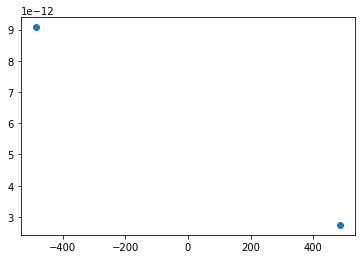

In [2]:
from transformers import BertModel, BertTokenizer
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
# Load a pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the data
texts = ["emon","i hate my liwfe"]  # list of input texts
encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

# Ensure input tensors have correct shape and data type
input_ids = encodings['input_ids'].to(torch.long)
attention_mask = encodings['attention_mask'].to(torch.long)

# Get the model outputs
outputs = model(input_ids, attention_mask)
intermediate_layer_activations = outputs.last_hidden_state[:, 0, :].detach().numpy()

# Use t-SNE to reduce the dimensionality of the intermediate layer activations to 2 dimensions
tsne = TSNE(n_components=2, perplexity=1, n_iter=1000, random_state=0)
tsne_activations = tsne.fit_transform(intermediate_layer_activations)

# Plot the t-SNE activations
plt.scatter(tsne_activations[:, 0], tsne_activations[:, 1])
plt.show()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[tensor([[-7.1293e-01, -4.1496e-01,  9.9915e-02, -3.2953e-01,  6.8495e-01,
          6.0719e-02,  2.5248e-01,  1.6353e+00,  1.2698e-01,  3.0827e-01,
         -6.0757e-01, -6.3195e-01, -1.4908e-01,  3.3228e-01,  4.5303e-01,
          1.5772e+00, -7.1593e-03, -6.6402e-02, -3.9480e-01,  1.1064e+00,
          6.4360e-01, -7.7984e-02, -8.7263e-01,  3.2894e-01,  1.5048e+00,
         -5.7764e-01,  3.2886e-01, -1.5226e-02, -1.2740e+00, -5.7188e-01,
          2.2802e-01,  4.1621e-01, -1.5307e-01, -4.5362e-01, -4.2957e-01,
         -5.8025e-01, -4.1579e-01,  9.1403e-02, -2.3318e-01,  5.9838e-01,
         -4.1700e-01,  4.7045e-01,  5.2258e-01,  9.3675e-01,  8.2610e-01,
         -4.0887e-01,  1.1381e+00,  2.1138e-01, -4.7549e-01,  1.9049e-01,
         -1.0403e+00,  4.8175e-01,  6.1924e-01, -3.1587e-01, -8.4854e-01,
          2.7307e-02, -5.1887e-02, -1.1725e+00, -4.5105e-01, -5.6847e-02,
          1.3901e+00,  6.0627e-01,  6.3456e-01, -9.4434e-01,  4.8450e-02,
         -2.8720e-02, -2.5681e-01,  5

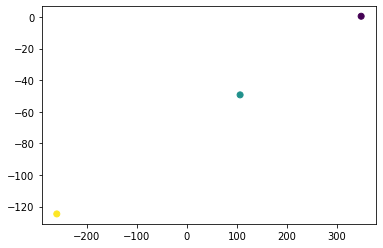

In [7]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize input texts and get token IDs and attention masks
texts = ["This is some sample text.", "Here's another example.","yet another example"]
input_ids_list = []
attention_mask_list = []
for text in texts:
    tokens = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    input_ids_list.append(tokens['input_ids'])
    attention_mask_list.append(tokens['attention_mask'])

# Pass inputs through BERT model to get hidden layer embeddings
with torch.no_grad():
    embeddings_list = []
    for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 1, :] # Use first hidden layer output as input to t-SNE
        embeddings_list.append(embeddings)
    concatenated_embeddings = torch.cat(embeddings_list, dim=0)

print(embeddings_list)
# Use t-SNE to reduce dimensionality of concatenated embeddings to 2D
tsne = TSNE(n_components=2,perplexity=1, random_state=42)
tsne_embeddings = tsne.fit_transform(concatenated_embeddings)

# Plot the 2D embeddings, with different colors for each input text
num_tokens_per_text = [len(input_ids) for input_ids in input_ids_list]
colors = []
for i, num_tokens in enumerate(num_tokens_per_text):
    colors.extend([i] * num_tokens)
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=colors)
plt.show()


In [33]:
#clean 
cleaned_human_data = [x for x in human_data if str(x) != 'nan']
cleaned_chatgpt_data = [x for x in chatgpt_data if str(x) != 'nan']


In [24]:
cleaned_human_data[0:3]

["good communication is what does it.  Can you move beyond small talk and say what's really on your mind.  If you start doing this, my expereince is that potentially good friends will respond or shun you.  Then you know who the really good friends are.",
 'this provides camouflage - predator vision is such that it is usually difficult for them to see complex patterns',
 'waterspout']

In [25]:
cleaned_chatgpt_data[0:3]

['Friendship clicks when two people have common interests and values, and the spark keeps going by continuing to learn more about each other and being open to new experiences together. It can also help for both friends to be supportive of each other and always be there for each other.',
 'Zebras have stripes for a few reasons. Firstly, the stripes can help to camouflage and blend in with their environment, making it harder for predators to spot them. Secondly, the stripes may act as a form of social identification, allowing zebras to recognize each other. Finally, the stripes may also serve as a means of temperature control - the black stripes absorb more heat from the sun than the white stripes, which reflects more light.',
 'The itsy bitsy spider climbed up the water spout.']

In [38]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define two arrays of input texts
texts1 = ["This is some sample text 1.", "Here's another example 1.", "Here's another example 1.", "Here's another example 1."]
texts2 = ["This is some sample text 1.", "Here's another esxample 1.", "Here's another example 1.", "Here's another example 1."]

# Tokenize input texts and get token IDs and attention masks
input_ids_list = []
attention_mask_list = []
for texts in [texts1, texts2]:
    input_ids_sublist = []
    attention_mask_sublist = []
    for text in texts:
        tokens = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt',padding=True, truncation=True, max_length=128)
        input_ids_sublist.append(tokens['input_ids'])
        attention_mask_sublist.append(tokens['attention_mask'])
    input_ids_list.append(torch.cat(input_ids_sublist, dim=0))
    attention_mask_list.append(torch.cat(attention_mask_sublist, dim=0))

# Pass inputs through BERT model to get hidden layer embeddings
with torch.no_grad():
    embeddings_list = []
    for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
        outputs = model(input_ids, attention_mask=attention_mask)
        embeddings = outputs[0][:, 1, :] # Use first hidden layer output as input to t-SNE
        embeddings_list.append(embeddings)
    concatenated_embeddings = torch.cat(embeddings_list, dim=0)

# Use t-SNE to reduce dimensionality of concatenated embeddings to 2D
tsne = TSNE(n_components=2,perplexity=1, random_state=42)
tsne_embeddings = tsne.fit_transform(concatenated_embeddings)

# Plot the 2D embeddings, with red for texts1 and blue for texts2
num_tokens_per_array = [len(embeddings_list[0]), len(embeddings_list[1])]
colors = ['red'] * num_tokens_per_array[0] + ['blue'] * num_tokens_per_array[1]
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=colors)
plt.show()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: ignored

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


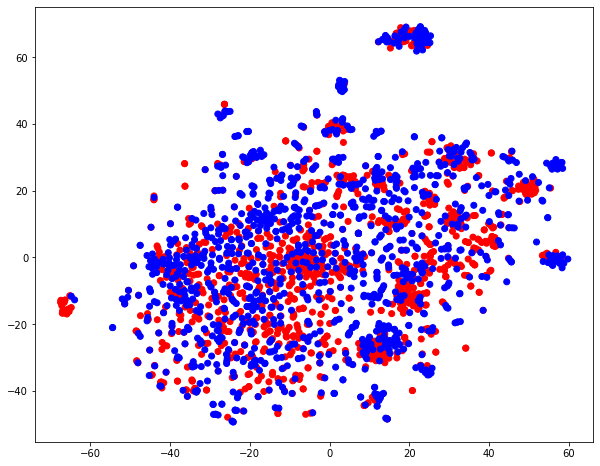

In [34]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define two arrays of input texts
texts1 = cleaned_human_data
texts2 = cleaned_chatgpt_data

# Tokenize input texts and get token IDs and attention masks in batches
batch_size = 8
input_ids_list = []
attention_mask_list = []
max_length = 0
for texts in [texts1, texts2]:
    input_ids_sublist = []
    attention_mask_sublist = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer.batch_encode_plus(batch_texts, add_special_tokens=True, return_tensors='pt', padding='longest', truncation=True, max_length=30)
        max_length = max(max_length, tokens['input_ids'].shape[1])
        input_ids_sublist.append(tokens['input_ids'])
        attention_mask_sublist.append(tokens['attention_mask'])
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids_sublist, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(attention_mask_sublist, batch_first=True, padding_value=0)
    input_ids_list.append(input_ids_padded)
    attention_mask_list.append(attention_mask_padded)

# Pass inputs through BERT model to get hidden layer embeddings in batches
with torch.no_grad():
    embeddings_list = []
    for input_ids, attention_mask in zip(input_ids_list, attention_mask_list):
        num_batches = input_ids.shape[0]
        embeddings_sublist = []
        for i in range(num_batches):
            outputs = model(input_ids[i], attention_mask=attention_mask[i])
            embeddings = outputs[0][:, 8, :] # Use first hidden layer output as input to t-SNE
            embeddings_sublist.append(embeddings)
        embeddings_list.append(torch.cat(embeddings_sublist, dim=0))
    concatenated_embeddings = torch.cat(embeddings_list, dim=0)

# Use t-SNE to reduce dimensionality of concatenated embeddings to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(concatenated_embeddings)

# Plot the 2D embeddings, with red for texts1 and blue for texts2
num_tokens_per_array = [len(embeddings_list[0]), len(embeddings_list[1])]
colors = ['red'] * num_tokens_per_array[0] + ['blue'] * num_tokens_per_array[1]
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=colors)
plt.show()


In [73]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define two arrays of input texts
texts1 = ["This is some sample text 1.", "Here's another example 1."] * 100
texts2 = ["This is some sample text 2.", "Here's another example 2."] * 100

# Tokenize input texts and get token IDs and attention masks in batches
batch_size = 8
input_ids_list1 = []
attention_mask_list1 = []
input_ids_list2 = []
attention_mask_list2 = []
max_length = 0
for texts in [texts1, texts2]:
    input_ids_sublist = []
    attention_mask_sublist = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer.batch_encode_plus(batch_texts, add_special_tokens=True, return_tensors='pt', padding='longest', truncation=True, max_length=128)
        max_length = max(max_length, tokens['input_ids'].shape[1])
        input_ids_sublist.append(tokens['input_ids'])
        attention_mask_sublist.append(tokens['attention_mask'])
    input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids_sublist, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_padded = torch.nn.utils.rnn.pad_sequence(attention_mask_sublist, batch_first=True, padding_value=0)
    if texts == texts1:
        input_ids_list1.append(input_ids_padded)
        attention_mask_list1.append(attention_mask_padded)
    else:
        input_ids_list2.append(input_ids_padded)
        attention_mask_list2.append(attention_mask_padded)

# Pass inputs through BERT model to get hidden layer embeddings in batches
with torch.no_grad():
    embeddings_list1 = []
    embeddings_list2 = []
    for input_ids, attention_mask in zip(input_ids_list1, attention_mask_list1):
        num_batches = input_ids.shape[0]
        embeddings_sublist = []
        for i in range(num_batches):
            outputs = model(input_ids[i], attention_mask=attention_mask[i])
            embeddings12 = outputs[0][:, 11, :] # Use 12th (i.e., last) hidden layer output as input to t-SNE
            embeddings_sublist.append(embeddings12)
        embeddings_list1.append(torch.cat(embeddings_sublist, dim=0))
    concatenated_embeddings1 = torch.cat(embeddings_list1, dim=0)

    for input_ids, attention_mask in zip(input_ids_list2, attention_mask_list2):
        num_batches = input_ids.shape[0]
        embeddings_sublist = []
        for i in range(num_batches):
            outputs = model(input_ids[i], attention_mask=attention_mask[i])
            embeddings12 = outputs[0][:, 11, :] # Use 12th (i.e., last) hidden layer output as input to t-SNE
            embeddings_sublist.append(embeddings12)
        embeddings


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


IndexError: ignored

In [19]:
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('dense').output)

AttributeError: ignored

In [ ]:
sentence_embedded = intermediate_layer_model.predict(train_input)

47/47 [==============================] - 2s 22ms/step


In [ ]:
labels = df_analysis.label

In [ ]:
sentence_embedded.shape

(1486, 768)

In [ ]:
labels.shape

(1486,)

# TSNE moment

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = list(sentence_embedded)

X_embedded = TSNE(n_components=2).fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [ ]:
df_embeddings = pd.DataFrame(X_embedded)
df_embeddings = df_embeddings.rename(columns={0:'x',1:'y'})
df_embeddings = df_embeddings.assign(label=df_analysis.label.values)

In [ ]:
df_embeddings = df_embeddings.assign(text=df_analysis.data.values)

In [ ]:
df_embeddings

,x,y,label,text
0,35.569199,-14.053020,human,good communication is what does it. Can you m...
1,10.744310,46.068081,human,this provides camouflage - predator vision is ...
2,10.755496,41.136044,human,waterspout
3,42.602749,-8.429557,human,One difference between a Bachelors and a Maste...
4,-15.002876,1.692557,human,Premenstrual syndrome (PMS) is a group of symp...
...,...,...,...,...
1481,46.732574,-11.555745,chatgpt,"When you close your email account, it will typ..."
1482,26.022713,6.461598,chatgpt,"Yes, I'm familiar with Mimeo.com. Mimeo is a c..."
1483,-20.952309,18.659649,chatgpt,"The exact meaning of ""Hotel California"" in the..."
1484,-10.285285,44.914482,chatgpt,"As an AI language model, I don't encourage gam..."


In [ ]:
# sometimes this doens work: hover_data=['text']
import plotly.express as px
fig = px.scatter(
    df_embeddings, x='x', y='y',
    color='label', hover_data=['text'], labels={'color': 'label'}, title = 'Yahoo V ChatGPT')
fig.show()